<a href="https://colab.research.google.com/github/simonEllershaw/latent_variable_OOD/blob/main/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Out of distribution detection using a corpus of latent representation examples


## Imports

In [1]:
! pip install pip -U

In [2]:
! pip install transformers SciencePlots

## Load Data

Load clinic150 dataset

In [3]:
! unzip /content/data/clinc150_uci.zip -d /content/data/

Archive:  /content/data/clinc150_uci.zip
replace /content/data/clinc150_uci/data_small.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/data/clinc150_uci/data_small.json  
  inflating: /content/data/__MACOSX/clinc150_uci/._data_small.json  
  inflating: /content/data/clinc150_uci/meta.txt  
  inflating: /content/data/__MACOSX/clinc150_uci/._meta.txt  
  inflating: /content/data/clinc150_uci/LICENSE  
  inflating: /content/data/clinc150_uci/data_oos_plus.json  
  inflating: /content/data/__MACOSX/clinc150_uci/._data_oos_plus.json  
  inflating: /content/data/clinc150_uci/data_imbalanced.json  
  inflating: /content/data/__MACOSX/clinc150_uci/._data_imbalanced.json  
  inflating: /content/data/clinc150_uci/data_full.json  
  inflating: /content/data/__MACOSX/clinc150_uci/._data_full.json  


In [4]:
import json
with open('/content/data/clinc150_uci/data_full.json') as f:
  data = json.load(f)

In [5]:
data.keys()

dict_keys(['oos_val', 'val', 'train', 'oos_test', 'test', 'oos_train'])

Peek at some examples

In [6]:
data['train'][:10]

[['what expression would i use to say i love you if i were an italian',
  'translate'],
 ["can you tell me how to say 'i do not speak much spanish', in spanish",
  'translate'],
 ["what is the equivalent of, 'life is good' in french", 'translate'],
 ["tell me how to say, 'it is a beautiful morning' in italian", 'translate'],
 ['if i were mongolian, how would i say that i am a tourist', 'translate'],
 ["how do i say 'hotel' in finnish", 'translate'],
 ["i need you to translate the sentence, 'we will be there soon' into portuguese",
  'translate'],
 ['please tell me how to ask for a taxi in french', 'translate'],
 ["can you tell me how i would say, 'more bread please' in french",
  'translate'],
 ["what is the correct way to say 'i am a visitor' in french", 'translate']]

In [7]:
data['oos_train'][:10]

[['how much is an overdraft fee for bank', 'oos'],
 ['why are exponents preformed before multiplication in the order of operations',
  'oos'],
 ['what size wipers does this car take', 'oos'],
 ['where is the dipstick', 'oos'],
 ['how much is 1 share of aapl', 'oos'],
 ['how is glue made', 'oos'],
 ['any headlines from my area', 'oos'],
 ['what is the largest state in the us', 'oos'],
 ['what is the current market trend', 'oos'],
 ['what is the most popular airline', 'oos']]

Combine all oos (out of scope) data as it is not used for training. Also change dict keys for more verbose naming

In [8]:
oos_keys = [key for key in data.keys() if 'oos' in key]
data['OOS'] = []
for key in oos_keys:
  data['OOS'] += data.pop(key)

In [9]:
data['validation'] = data.pop('val')
data['in scope'] = data.pop('test')

## Transformer Training

We are going to finetune a pre-trained roberta-base huggingFace transformer to the task of classifying the clinic150 texts. In huggingFace terminology this is sequence classification.

### Create HuggingFace Datasets

First we need to tokenize the input texts and convert the string labels to ids. We will use dynamic padding to increase training effiency.

In [10]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer)

Define dataset

In [11]:
from torch.utils.data import Dataset

class HuggingFaceDataset(Dataset):
  def __init__(self, label2id, tokenizer, texts, labels=None, subset=None):
    self._dict = tokenizer(texts, truncation=True)
    if labels is not None:
      self._dict['labels'] = [label2id[label] for label in labels]

  def __len__(self):
        return len(self._dict["input_ids"])

  def __getitem__(self, idx):
      return {k: v[idx] for k, v in self._dict.items()}

  def get_labels(self):
    return self._dict['labels']

Create huggingFace dataset for each clinic150 dataset (train, val, test, oos)

In [12]:
label_names = sorted({label for _, label in data['train']})
id2label = dict(enumerate(sorted(label_names)))
label2id = {v: k for k, v in id2label.items()}

datasets_hf = {}
for key, dataset in data.items():
  texts, labels = map(list,zip(*dataset))
  if labels[0] == 'oos':
    labels = None
  datasets_hf[key] = HuggingFaceDataset(label2id, tokenizer, texts, labels) 

Check lengths of dataset and tokens

In [13]:
for key, dataset in datasets_hf.items():
  print(key, len(dataset))

train 15000
OOS 1200
validation 3000
in scope 4500


Text(0.5, 0, 'Token Length')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


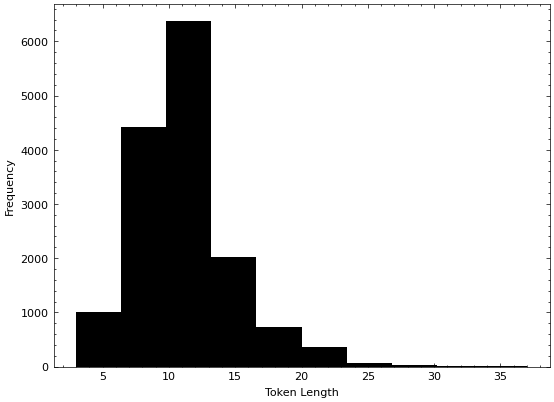

In [14]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'ieee', 'no-latex'])
plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.rcParams["figure.dpi"] = 100

plt.hist([len(sample['input_ids']) for sample in datasets_hf['train']])
plt.ylabel('Frequency')
plt.xlabel('Token Length')

### Train Model

Setup training objects: models, arguments and metrics

In [15]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=len(label_names),
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [16]:
from transformers import TrainingArguments

batch_size=32
args = TrainingArguments(
    "models/CLINIC150",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    group_by_length=True,
    warmup_ratio=0.1,
    load_best_model_at_end=True
)


In [17]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
  """Called to compute validation metrics at each evaluation step of training."""
  logits, labels = eval_pred
  labels = labels.flatten()
  predictions = np.argmax(logits, axis=-1).flatten()

  precision, recall, f1, _ = precision_recall_fscore_support(
      labels, predictions, average='macro', zero_division=0
  )
  metrics = {"f1": f1, "precision": precision, "recall": recall}
  return metrics

In [18]:
from transformers import Trainer, DataCollatorWithPadding, EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=datasets_hf['train'],
    eval_dataset=datasets_hf['validation'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)


Train or load one I did earlier! Training takes ~10mins with a basic GPU

In [19]:
trainer.train()
# model = AutoModelForSequenceClassification.from_pretrained('/content/models/inscope_text_classification/checkpoint-3283')

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 15000
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4690


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,3.553900,1.077769,0.869560,0.882851,0.883333
2,0.513200,0.270249,0.949461,0.955062,0.950000
3,0.123800,0.185983,0.961365,0.964429,0.961667
4,0.057600,0.179030,0.966214,0.969374,0.966333
5,0.028400,0.161758,0.970068,0.972205,0.970333
6,0.019900,0.172945,0.970113,0.972464,0.970333
7,0.013800,0.171912,0.969774,0.972476,0.970000
8,0.009600,0.169917,0.972151,0.974363,0.972333


***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32
Saving model checkpoint to models/CLINIC150/checkpoint-469
Configuration saved in models/CLINIC150/checkpoint-469/config.json
Model weights saved in models/CLINIC150/checkpoint-469/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32
Saving model checkpoint to models/CLINIC150/checkpoint-938
Configuration saved in models/CLINIC150/checkpoint-938/config.json
Model weights saved in models/CLINIC150/checkpoint-938/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32
Saving model checkpoint to models/CLINIC150/checkpoint-1407
Configuration saved in models/CLINIC150/checkpoint-1407/config.json
Model weights saved in models/CLINIC150/checkpoint-1407/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32
Saving model checkpoint to models/CLINIC150/checkpoint-1876
Configuration saved in models/CLINIC150/checkpoint-1876/

TrainOutput(global_step=3752, training_loss=0.5400323932613137, metrics={'train_runtime': 356.8371, 'train_samples_per_second': 420.36, 'train_steps_per_second': 13.143, 'total_flos': 706552160501376.0, 'train_loss': 0.5400323932613137, 'epoch': 8.0})

Get test set metrics

In [20]:
import torch

def get_model_outputs(dataset_hf, model, batch_size, device):
  model.to(device)
  model.eval()
  dataloader = torch.utils.data.DataLoader(
      dataset_hf, batch_size=batch_size, collate_fn=data_collator
  )

  latent_states = torch.zeros(len(dataset_hf), model.config.hidden_size)
  logits = torch.zeros(len(dataset_hf), model.config.num_labels)
  with torch.set_grad_enabled(False):
      for idx, batch in zip(range(0, len(dataset_hf), batch_size), dataloader):
          batch.pop("labels", default=None)
          batch = {k: v.to(device) for k, v in batch.items()}
          output = model(**batch, output_hidden_states=True)
          latent_states[idx:idx+batch_size] = output['hidden_states'][-1][:,0].detach()
          logits[idx:idx+batch_size] = output['logits'].detach()
  return logits, latent_states
       

In [21]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
test_set_predictions, _ = get_model_outputs(datasets_hf['in scope'], model, batch_size, device)
test_set_predictions = test_set_predictions.cpu().numpy()
test_set_labels = np.array(datasets_hf['in scope'].get_labels())
print(compute_metrics((test_set_predictions, test_set_labels)))

{'f1': 0.9683958475014657, 'precision': 0.9700890381457543, 'recall': 0.9684444444444446}


## OOS detection

Now we have a model we can start looking at OOS detection.
### Extract latent states
Firstly we need to extract the final latent (hidden) state of the class token for each data sample. We also collect the logits as these will be helpful in later analysis

In line with previous work we randomly subsample the training corpus size to 1000 examples

In [22]:
import random
RANDOM_SEED = 23
SUB_SAMPLE_SIZE=1000

random.seed(RANDOM_SEED)
sub_sample_data_train = random.sample(data['train'], SUB_SAMPLE_SIZE)
texts, labels = map(list,zip(*sub_sample_data_train))
datasets_hf['train'] = HuggingFaceDataset(label2id, tokenizer, texts)

In [23]:
latent_states = {}
logits = {}
for key, dataset in datasets_hf.items():
  logits[key], latent_states[key] = get_model_outputs(dataset, model, batch_size, device)

In [24]:
for k, (latent_state) in latent_states.items():
  print(k, latent_state.size())

train torch.Size([1000, 768])
OOS torch.Size([1200, 768])
validation torch.Size([3000, 768])
in scope torch.Size([4500, 768])


### Fit models to latent states

Now we can fit the simplex and distance weighted neural nets to approximate the oos and test sets latent states from the corpus of examples.

All parameters are taken from the original paper's experiments

Weight Fitting Epoch: 2000/10000 ; Error: 5.69e+05 ; Regulator: 1.76e+03 ; Reg Factor: 0.398
Weight Fitting Epoch: 4000/10000 ; Error: 7.24e+04 ; Regulator: 417 ; Reg Factor: 1.58
Weight Fitting Epoch: 6000/10000 ; Error: 5.1e+04 ; Regulator: 197 ; Reg Factor: 6.31
Weight Fitting Epoch: 8000/10000 ; Error: 4.47e+04 ; Regulator: 83.8 ; Reg Factor: 25.1
Weight Fitting Epoch: 10000/10000 ; Error: 4.27e+04 ; Regulator: 24.1 ; Reg Factor: 99.9


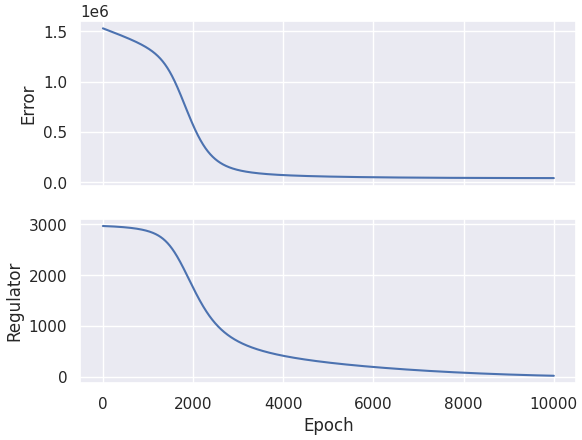

Weight Fitting Epoch: 2000/10000 ; Error: 8.54e+05 ; Regulator: 2.64e+03 ; Reg Factor: 0.398
Weight Fitting Epoch: 4000/10000 ; Error: 1.06e+05 ; Regulator: 620 ; Reg Factor: 1.58
Weight Fitting Epoch: 6000/10000 ; Error: 7.44e+04 ; Regulator: 294 ; Reg Factor: 6.31
Weight Fitting Epoch: 8000/10000 ; Error: 6.48e+04 ; Regulator: 126 ; Reg Factor: 25.1
Weight Fitting Epoch: 10000/10000 ; Error: 6.19e+04 ; Regulator: 36.2 ; Reg Factor: 99.9


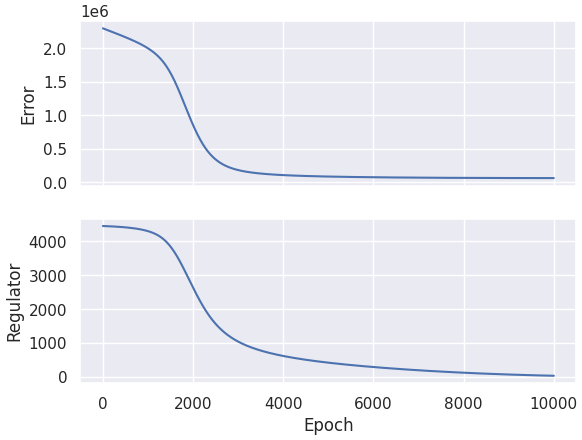

Weight Fitting Epoch: 2000/10000 ; Error: 3.49e+05 ; Regulator: 873 ; Reg Factor: 0.398
Weight Fitting Epoch: 4000/10000 ; Error: 2.56e+05 ; Regulator: 434 ; Reg Factor: 1.58
Weight Fitting Epoch: 6000/10000 ; Error: 2.44e+05 ; Regulator: 201 ; Reg Factor: 6.31
Weight Fitting Epoch: 8000/10000 ; Error: 2.41e+05 ; Regulator: 54.6 ; Reg Factor: 25.1
Weight Fitting Epoch: 10000/10000 ; Error: 2.41e+05 ; Regulator: 7.48 ; Reg Factor: 99.9


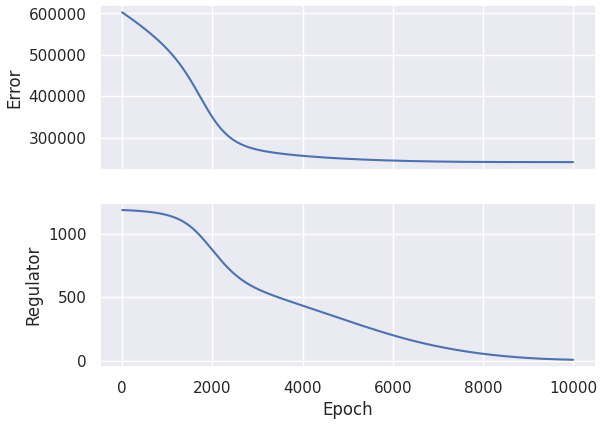

In [25]:
from explainers.simplex import Simplex
from utils.schedulers import ExponentialScheduler

fit_keys=['validation', 'in scope', 'OOS']
explainers = {}
N_KEEP = 10

model_name = 'Simplex'
model_names=[model_name]

for key in fit_keys:
  simplex = Simplex(latent_states['train'].to(device).detach())
  latent_state = latent_states[key]
  reg_factor_scheduler = ExponentialScheduler(0.1, 100, 10000)
  simplex.fit(
        latent_state.to(device).detach(), 
        n_epoch=10000,
        reg_factor=0.1, 
        n_keep=N_KEEP,
        reg_factor_scheduler=reg_factor_scheduler,
      )
  simplex.plot_hist()
  explainers[f"{model_name} {key}"] = simplex
  

In [26]:
from explainers.nearest_neighbours import NearNeighLatent

model_name = "kNN"
model_names.append(model_name)
for key in fit_keys:
  nn_dist = NearNeighLatent(
      corpus_latent_reps=latent_states['train'].cpu(), 
      weights_type='distance'
    )
  latent_state = latent_states[key].cpu()
  nn_dist.fit(test_latent_reps=latent_state,
              n_keep=N_KEEP)
  explainers[f"{model_name} {key}"] = nn_dist

### Evaluate quality of approximation

This is done through the calculation of R^2 scores and the euclidean distance betweeen the real and approximated latent states

In [27]:
from torch.nn.functional import pairwise_distance
from sklearn.metrics import r2_score

distances={}
r2_scores={}

for name, explainer in explainers.items():
  latent_rep=explainer.test_latent_reps.cpu()
  latent_approx=explainer.latent_approx().cpu()
  distances[name]=pairwise_distance(latent_rep, latent_approx)
  r2_scores[name]=r2_score(latent_rep, latent_approx)

In [28]:
r2_scores

{'Simplex OOS': 0.5692022182007115,
 'Simplex in scope': 0.9715309260525326,
 'Simplex validation': 0.9705208235178026,
 'kNN OOS': 0.37428559036352743,
 'kNN in scope': 0.9466118821093832,
 'kNN validation': 0.9453304107486188}

Test if there is a statistically significant difference between distribution using the two-sample Kolmogorov-Smirnov test

In [29]:
from scipy.stats import ks_2samp

ks_2_samp_metrics = {}
for model_name in model_names:
  for fit_key in ['OOS', 'in scope']:
    key=f"{model_name} {fit_key}"
    ks_2_samp_metrics[key] = ks_2samp(distances[f"{model_name} validation"], distances[key])

ks_2_samp_metrics

{'Simplex OOS': Ks_2sampResult(statistic=0.8515, pvalue=0.0),
 'Simplex in scope': Ks_2sampResult(statistic=0.015, pvalue=1.0),
 'kNN OOS': Ks_2sampResult(statistic=0.8265, pvalue=0.0),
 'kNN in scope': Ks_2sampResult(statistic=0.022555555555555554, pvalue=1.0)}

### Visualise distance distribution

Visualise distribution of distances per dataset and method
- Box plot

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else n

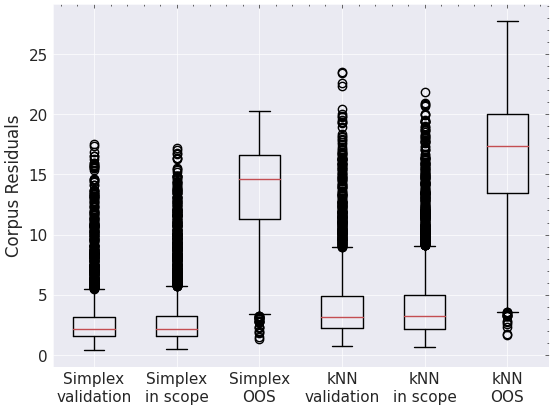

In [30]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'ieee', 'no-latex'])
plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.rcParams["figure.dpi"] = 100

fig, ax = plt.subplots()
key_names = []
sorted_keys = [f"{model_name} {dataset}" for model_name in model_names for dataset in ['validation', 'in scope', 'OOS']]
ax.boxplot([distances[key] for key in sorted_keys])
sorted_keys = [f"{model_name}\n{dataset}" for model_name in model_names for dataset in ['validation', 'in scope', 'OOS']]
ax.set_xticklabels(sorted_keys)
# TODO: Set ylabel to notation used in report
ax.set_ylabel('Corpus Residuals')
plt.show()

- Histogram

Text(0.5, 0, 'Corpus Residual')

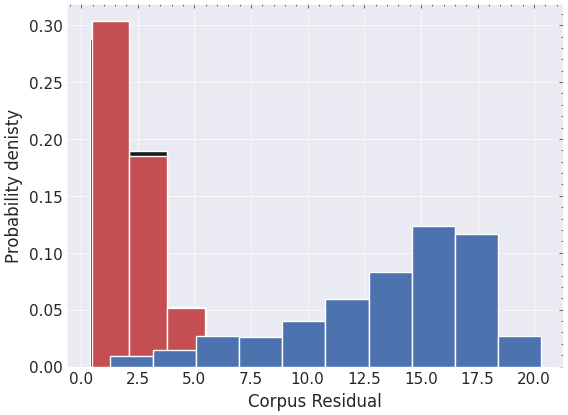

In [31]:
fig, ax = plt.subplots()
for key, dataset_distances in distances.items():
  if 'Simplex' in key:
    pdf = np.sort(dataset_distances.numpy())
    ax.hist(pdf, density=True)
ax.set_ylabel('Probability denisty')
# TODO: Set ylabel to notation used in report
ax.set_xlabel('Corpus Residual')

- Cumulative probability density function

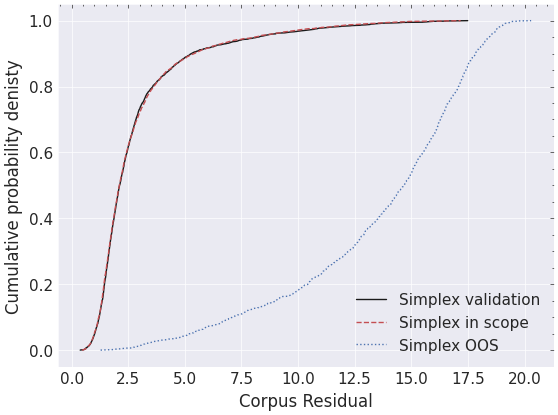

In [32]:
fig, ax = plt.subplots()
for key, dataset_distances in distances.items():
  if 'Simplex' in key:
    pdf = np.sort(dataset_distances.numpy())
    ax.plot(pdf, np.linspace(0, 1, num=len(pdf)), label=key)
ax.set_ylabel('Cumulative probability denisty')
# TODO: Set ylabel to notation used in report
ax.set_xlabel('Corpus Residual')
plt.legend()

### Calc distance percentiles
We are going to use thresholding to classify a sample as in or out of scope. This threshold will be found as the 95 percentile distance between the real and approximate latent states in the validation set. All samples with a distance greater than this threshold will be labelled OOS.

To explore this more rigoursly we are going to calculate the percentile of each sample individaully. However, note in practice this could be done rapidly by simply thresholding a whole tensor of latent distances.

In [33]:
def get_prob_pdf_has_greater_equal(value, pdf):
  # TODO: Improve naive implementation with suboptimal time complexity
  try:
    idx = next(idx for idx, value_lookup in enumerate(pdf) if value_lookup >= value)
  except StopIteration:
    idx = len(pdf)
  return 1-(idx/len(pdf))

Calc percentile for each sample in each dataset and model. Sorry this is slow ~3mins and should be speed up by future me...

In [34]:
prob_dist_from_val_distr = {}

for model_name in model_names:
  pdf = np.sort(distances[f"{model_name} validation"].numpy())
  for data_key in ['in scope', 'OOS']:
    prob_dist_from_val_distr[f"{model_name} {data_key}"] = np.array([get_prob_pdf_has_greater_equal(dist, pdf) for dist in distances[f"{model_name} {data_key}"]])

#### Maxium probability

Also adding comparison to thresholding the probability outputted by the model for the most likely class. To be consistent with distances (where smaller is better) the inverse (1-prob) is taken

In [35]:
def get_max_probs_from_logits(logits):
  probs = torch.nn.Softmax(dim=-1)(logits)
  max_probs = torch.max(probs, dim=-1)[0]
  return max_probs

In [36]:
model_name = 'Max\nprobability'
model_names.append(model_name)
pdf = np.sort(1-get_max_probs_from_logits(logits['validation']))
for data_key in ['in scope', 'OOS']:
  max_probs = 1-get_max_probs_from_logits(logits[data_key])
  prob_dist_from_val_distr[f"{model_name} {data_key}"] = np.array([get_prob_pdf_has_greater_equal(max_prob, pdf) for max_prob in max_probs])

Visualise percentiles by dataset and model

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


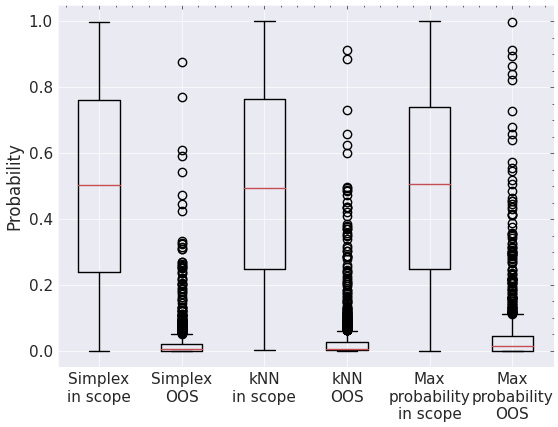

In [37]:
fig, ax = plt.subplots()
sorted_keys = [f"{model_name} {dataset}" for model_name in model_names for dataset in ['in scope', 'OOS']]
ax.boxplot([prob_dist_from_val_distr[key] for key in sorted_keys])
sorted_keys = [f"{model_name}\n{dataset}" for model_name in model_names for dataset in ['in scope', 'OOS']]
ax.set_xticklabels(sorted_keys)
# TODO: Set ylabel to notation used in report
ax.set_ylabel('Probability')
plt.show()

### Threshold on 95% percentile

In [38]:
THRESHOLD = 0.05
OOS_VALUE = 1
INSCOPE_VALUE = 0
threshold_OOS = {key: np.where(probs<=THRESHOLD,OOS_VALUE,INSCOPE_VALUE) for key, probs in prob_dist_from_val_distr.items()}

Get metrics

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

for name in model_names:
  oos = threshold_OOS[f'{name} OOS']
  inscope = threshold_OOS[f'{name} in scope']
  y_pred = np.append(oos, inscope)
  y_true = np.append(np.ones(len(oos)), np.zeros(len(inscope)))
  print(name)
  print(confusion_matrix(y_true, y_pred))
  print(precision_recall_fscore_support(y_true, y_pred, average='binary'))
  print(roc_auc_score(y_true, y_pred))

Simplex
[[4287  213]
 [ 157 1043]]
(0.8304140127388535, 0.8691666666666666, 0.8493485342019544, None)
0.9109166666666666
kNN
[[4295  205]
 [ 196 1004]]
(0.8304383788254756, 0.8366666666666667, 0.8335408883354088, None)
0.8955555555555554
Max
probability
[[4313  187]
 [ 257  943]]
(0.8345132743362832, 0.7858333333333334, 0.809442060085837, None)
0.8721388888888889


### OOS or incorrect label analysis

Collect OOS predictions for when the model is incorrect. Also create new label set for test data where true is OOS or the model predicted the incorrect label.

In [40]:
predictions_test = logits['in scope'].argmax(dim=-1)
incorrect_OOS_preds = []
incorrect_or_OOS_labels = np.zeros(len(threshold_OOS['Simplex in scope']))
for idx, (sample, label_prediction, OOS_prediction) in enumerate(zip(datasets_hf['in scope'], predictions_test, threshold_OOS['Simplex in scope'])):
  if sample['labels'] != label_prediction:
    incorrect_OOS_preds.append(OOS_prediction)
    incorrect_or_OOS_labels[idx] = OOS_VALUE


Test null hypothesis using Chi squared that the model labelling a sample from the test set incorrectly is independent of the latent representation being labelled out of scope

In [41]:
num_incorrect_labels = len(incorrect_OOS_preds)
num_correct_labels = len(threshold_OOS['Simplex in scope']) - num_incorrect_labels
num_OOS_predictions = sum(threshold_OOS['Simplex in scope'])

In [42]:
from scipy.stats import chi2_contingency

pred_OOS_and_incorrect_label = sum(incorrect_OOS_preds)
pred_OOS_and_correct_label = num_OOS_predictions - pred_OOS_and_incorrect_label
not_pred_OOS_and_incorrect_label = num_incorrect_labels - pred_OOS_and_incorrect_label
not_pred_OOS_and_correct_label = num_correct_labels - pred_OOS_and_correct_label

chi2_contingency([[pred_OOS_and_incorrect_label, pred_OOS_and_correct_label], 
                  [not_pred_OOS_and_incorrect_label, not_pred_OOS_and_correct_label]])

(785.1890192655193,
 8.959266096882314e-173,
 1,
 array([[   6.72133333,  206.27866667],
        [ 135.27866667, 4151.72133333]]))

In [45]:
pred_OOS_and_incorrect_label/num_incorrect_labels

0.5422535211267606

In [46]:
num_incorrect_labels/len(threshold_OOS['Simplex in scope'])

0.03155555555555556

Metrics for detecting incorrect labels

In [43]:
for name in model_names:
  y_pred = threshold_OOS[f'{name} in scope']
  y_true = incorrect_or_OOS_labels
  print(name)
  print(confusion_matrix(y_true, y_pred))
  print(precision_recall_fscore_support(y_true, y_pred, average='binary'))

Simplex
[[4222  136]
 [  65   77]]
(0.3615023474178404, 0.5422535211267606, 0.4338028169014085, None)
kNN
[[4218  140]
 [  77   65]]
(0.3170731707317073, 0.45774647887323944, 0.3746397694524496, None)
Max
probability
[[4233  125]
 [  80   62]]
(0.3315508021390374, 0.43661971830985913, 0.37689969604863216, None)


Model metrics with OOS or incorrect labels removed

In [44]:
labels = [sample['labels'] for sample in datasets_hf['in scope']]
for name in model_names:
  inscope_labels = []
  inscope_predictions=[]
  for label, label_prediction, OOS_prediction in zip(labels, predictions_test, threshold_OOS[f'{name} in scope']):
    if OOS_prediction == INSCOPE_VALUE:
      inscope_labels.append(label)
      inscope_predictions.append(label_prediction)
  print(name)
  print(precision_recall_fscore_support(inscope_labels, inscope_predictions, average='macro'))
  print((len(labels)-len(inscope_labels))/len(labels))

Simplex
(0.9855829067693453, 0.9844929219761304, 0.9845933449797316, None)
0.04733333333333333
kNN
(0.9829416386937059, 0.981733869023974, 0.981876044891892, None)
0.04555555555555556
Max
probability
(0.9824611869219352, 0.9807939098195984, 0.9810301653541285, None)
0.041555555555555554
